# 第二章 端到端的机器学习项目

## 准备工作

Scikit-Learn简介：

估算器：fit()

转换器：transform()

可以使用fit_transfrom()方法一步到位，但是fit_transform()输入需要一个二维数组，可以使用reshape函数转换。

预测器：predict(),返回一个包含相应预测的数据集，使用score()方法衡量测试集的预测质量。

所有估算器的超参数可以通过公共实例变量来访问（如：imputer.strategy），所有估算器的学习参数可以通过下划线后缀的公共实例变量来访问（如：imputer.strategy_）。

数据集被标识为NumPy数组或是SciPy稀疏矩阵。

任意序列的转换器最后加一个预测器就可以构成一个流水线。

Scikit-Learn为大多数参数设置了合理的默认值。

In [39]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")# , CHAPTER_ID

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 获取数据

In [40]:
import os
import tarfile
from six.moves import urllib

In [41]:
# 定义数据源及存储位置
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [42]:
# 定义获取数据的函数
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [43]:
# 获取数据
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

## 快速查看数据结构

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# 定义读取数据的函数
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [46]:
# 定义读取数据函数
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [47]:
housing = load_housing_data(HOUSING_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [48]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [49]:
# 使用value_counts()函数统计某一列的分类情况
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [50]:
#使用describe()函数显示数值属性的摘要
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


使用describe()函数显示数值属性的摘要
count，mean，max，min很清楚，但是不包括空值
std表示标准差：衡量数据的离散程度
25%，50%，75%表示百分位数：百分位数表示一组观测值中给定百分比的观测值都小于该值。如：latitude的25%为33.93，表示latitude中小于33.93的值有25%。
25%也称为百分之二十五分位数（第一四分位数）
50%也称为中位数
75%也称为百分之七十五分位数（第三四分位数）

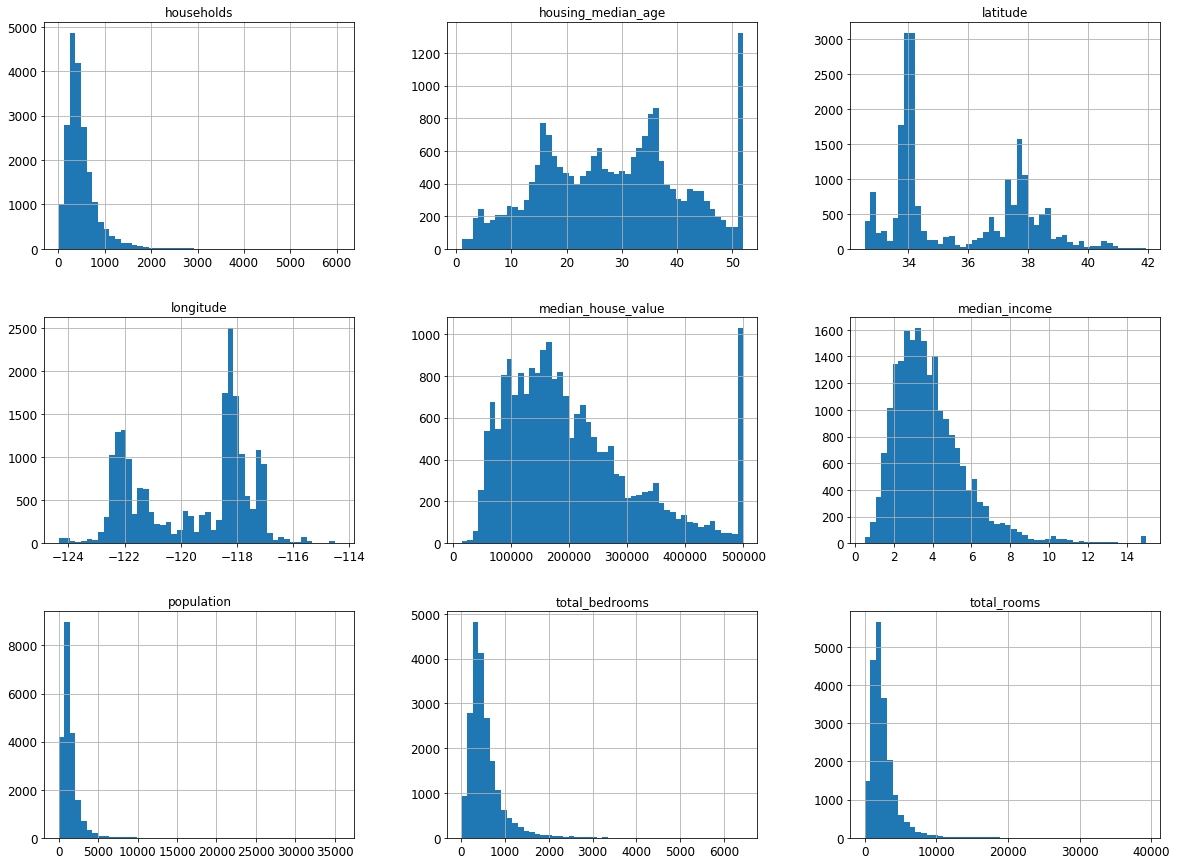

In [51]:
# 还可以通过直方图快速了解数据类型
# %matplotlib inline
housing.hist(bins=50, figsize=(20, 15))
plt.show()# 在jupyter中show方法调用可选

从图中看出，各个属性值被缩放的程度各不相同，房龄中位数和房价中位数的上限被限制了。
许多直方图表现出了重尾：在中位数右侧的延伸比在左侧的延伸远得多，后面会处理将它们转换为钟形（正态）。

## 创建测试集
暂时搁置创建测试集以避免出现窥探偏误

采用纯随机抽样会导致抽样偏差

采用分层抽样（分层次后按比例抽取）才能更好的选取更具代表性的样本，效果更好

分层抽样的要求：

保证每一层都有足够多的实例，也就是说，不应该把层数分的太多。

在预测房价平均值中，收入中位数是一个非常重要的属性，因此从收入中位数入手。1、将收入中位数除以1.5（限制收入类别的数量）。2、使用ceil函数取整。3、最后将所有大于5的类别合并为类别5。

In [52]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

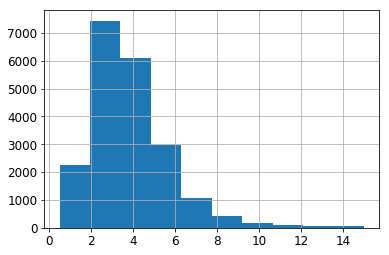

Saving figure 收入中位数的直方图


<Figure size 432x288 with 0 Axes>

In [53]:
# 收入中位数的直方图，大部分在2-5
# %matplotlib inline
housing["median_income"].hist()
plt.show()
save_fig("收入中位数的直方图")

In [54]:
# 对收入中位数除以1.5，再取整，再将大于5的合并为类别5
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Saving figure 分类后的数据的比例分布直方图


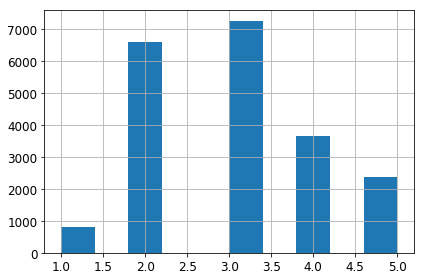

In [55]:
housing["income_cat"].hist()# 分类后的数据的直方图
housing["income_cat"].value_counts() / len(housing) # 分类后的数据的比例分布
save_fig("分类后的数据的比例分布直方图")

In [56]:
# 根据收入类别分层抽样
'''
random_state参数等同于np.random.seed,即：随机生成器种子，设置42是因为42是生命，宇宙，一切的答案
参数n_splits是将训练数据分成train/test对的组数，可根据需要进行设置，默认为10
'''
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    start_train_set = housing.loc[train_index]
    start_test_set = housing.loc[test_index]

In [57]:
# 测试集中数据比例分布
start_test_set["income_cat"].value_counts() / len(start_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [58]:
# 删除income_cat属性
for set in (start_train_set, start_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## 从数据探索和可视化中获得洞见

这一步不一定要非常彻底，关键是要迈出一步。

可以在原型中分析它的输出并再次回到探索的步骤

如果数据集非常大，可以抽样出一个探索集

本例中数据不是很多，可以直接操作。

In [59]:
# 先创建一个副本，从而操作不损害训练集。
housing = start_train_set.copy()

### 地理数据可视化

Saving figure 数据的地理分布图


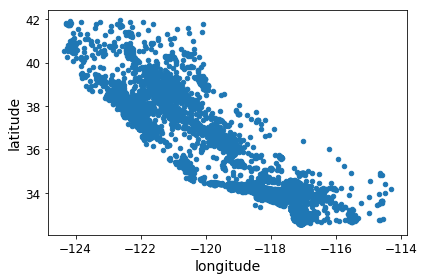

In [60]:
# longitude:经度
# latitude:维度
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("数据的地理分布图")

Saving figure 突出高密度区域的可视化


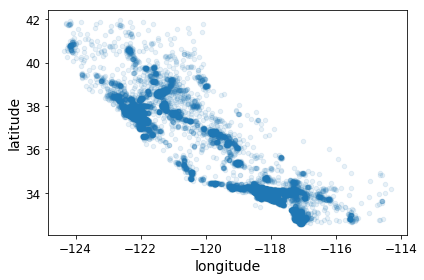

In [61]:
# 突出高密度区域的可视化，设置alpha为0.1
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("突出高密度区域的可视化")

Saving figure 加利福尼亚州房屋价格


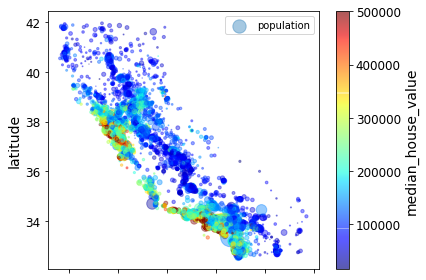

In [62]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
save_fig("加利福尼亚州房屋价格")

每个圆的半径大小代表了每个地区的人口数量，颜色代表价格，使用jet预定义的颜色表可视化显示，颜色从蓝（低）到红（高）

Saving figure california_housing_prices_plot


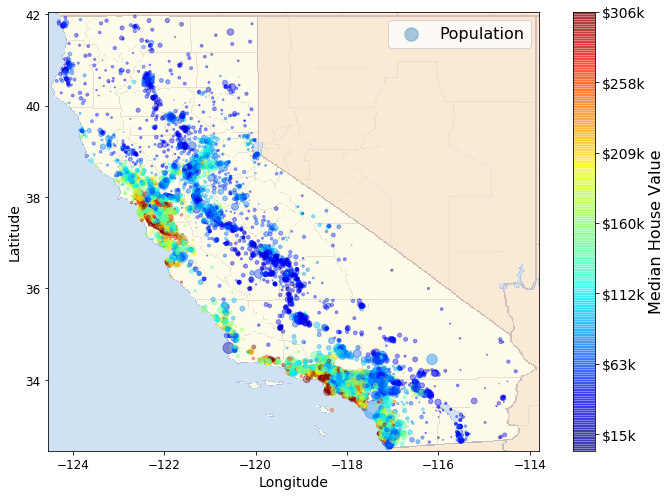

In [63]:
# 将地理图与真实地图结合绘制（代码重用）
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### 寻找相关性

In [64]:
# 计算每对属性的标准相关系数
corr_matrix = housing.corr()

In [65]:
# 查看每个属性与房屋中位数的相关性
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

相关系数从-1到1，越接近1，表明有越强的正相关；越接近-1，表明有越强的负相关；系数越靠近0表明二者之间没有线性相关性。

相关系数仅测量线性相关性，可能会忽略了非线性相关。

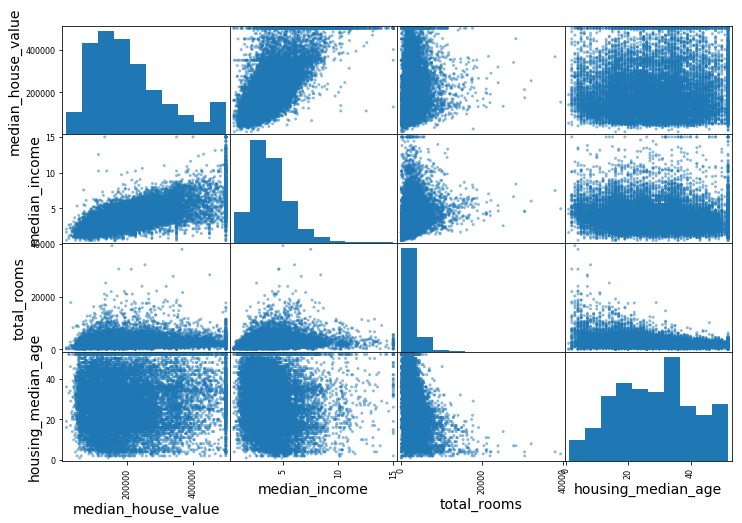

In [66]:
# 使用pandas中的scatter_matrix函数绘制出每个数值属性相对于其他数值属性的相关性
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Saving figure 收入中位数与房价中位数


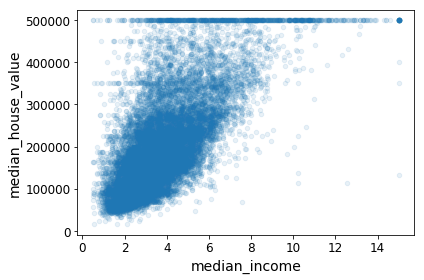

In [67]:
# 将与房价中位数最相关的收入中位数单独绘制
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
save_fig("收入中位数与房价中位数")

### 试验不同属性的组合

将一些似乎不是很有用，没有太大意义的属性进行组合，再考察相关性，可能会有新的发现。

In [68]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [69]:
# 查看相关性
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## 机器学习算法的数据准备

首先获得一个干净的训练集，并将预测器和标签分开

In [70]:
housing = start_train_set.drop("median_house_value", axis=1)
housing_labels = start_train_set["median_house_value"].copy()

### 数据清洗

"total_bedrooms"属性中有部分值缺失，可以用以下三种方法：

1、放弃这些空值数据

2、放弃这个属性

3、用某个值替代缺失值（0，平均数或者中位数）

可以使用pandas中的dropna(),drop(),fillna()函数实现

本例中使用Scikit-Learn中的imputer来处理缺失值：

In [71]:
# 创建一个imputer实例，指定要用属性的中位数来替代缺失值
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

E:\Programme\Anaconda\envs\AIDS\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [72]:
# 由于中位数只能在数值属性上计算，因此将含有文本属性的列去掉
housing_num = housing.drop("ocean_proximity", axis=1)
# 使用fit函数将imputer实例适配到训练集
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [73]:
# imputer将计算的结果存储在“statistics_”中
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [74]:
# 为了稳妥，将imputer应用于所有的数值属性
X = imputer.transform(housing_num)
# 结果是一个Numpy数组，转换成DataFrame结果
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [75]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


### 处理文本和分类属性

之前的"ocean_proximity"是一个文本属性列，无法计算他的中位数等。

可以使用Scikit-Learn的LabelEncoder来将文本属性学习后转换为数字。

但是转换后，在机器学习的过程中，算法可能会误判两个属性间的相似性。比如："ocean_proximity"列中各属性转换的情况为"<1H OCEAN", "INLAND", "ISLAND", "NEAR BAY", "NEAR OCEAN"(0, 1, 2, 3, 4)。机器学习算法可能会认为"<1H OCEAN"和"INLAND"两个属性更相似。实际是"<1H OCEAN"和"NEAR OCEAN"属性更相似。

因此，可以使用“独热编码”。比如，某行的"ocean_proximity"属性列值为"<1H OCEAN"，则在独热编码中该行的属性值为[1, 0, 0, 0, 0]。可以使用Scikit-Learn中的OneHotEncoder来转换。该函数经过计算后返回的是一个稀疏矩阵，并不是一个NunPy数组，稀疏矩阵的好处在于当数据量很大时，可以节省空间，并且只记录属性中非0项的位置。可以使用toarray()函数将稀疏矩阵转换成一个NumPy数组。

可以使用Scikit-Learn中的LabelBinarizer函数将文本转换成数字类别并转成独热编码，一步到位。该函数计算后返回的是一个NumPy数组。设置LabelBinarizer函数的sparse_output=True属性可以返回一个稀疏矩阵。

In [76]:
# 使用LabelBinarizer完成文本转换为数字类别再转换成独热编码
from sklearn.preprocessing import LabelBinarizer
housing_cat = housing["ocean_proximity"]
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### 自定义转换器

### 特征缩放

数据中的数值属性可能会有非常大的比例差异，可能会导致算法的性能表现不佳。但是目标值的数据往往不需要缩放。

可以使用最小-最大缩放或者标准化来同比例缩放所有属性。

最小-最大缩放（归一化），使用Scikit-Learn中的MinMaxScaler转换器实现。缩放的范围一般是0-1（神经网络的期望输入范围）。可以通过feature_range来修改缩放范围

标准化缩放的范围不是0-1，但标准化的方法受到异常值的影响较小。使用Scikit-Learn中的StandardScaler方法实现。

缩放器应该只用来拟合训练集，而不拟合测试集。